## This does run, but I had to remove details so secret keys wouldn't be exposed


In [1]:
#bring in relevant libraries
import pandas as pd
import json
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import numpy as np
import httplib, urllib
import re
import requests
import datetime
import time

In [1]:
import httplib, urllib, json, locale
from urlparse import urlparse

#!/usr/bin/python
#
# Demonstrates generating a payment report with the Square Connect API.
#
# This sample assumes all monetary amounts are in US dollars. You can alter the
# format_money function to display amounts in other currency formats.
#
# To run this script from the command line:
# python payments-report.py

import httplib, urllib, json, locale
from urlparse import urlparse


# Get this from your application dashboard (https://connect.squareup.com/apps)
# this is secret, don't share
access_token = ''

# Standard HTTP headers for every Connect API request
request_headers = {'Authorization': 'Bearer ' + access_token,
                   'Accept': 'application/json',
                   'Content-Type': 'application/json'}
  
# The base URL for every Connect API request
connection = httplib.HTTPSConnection('connect.squareup.com')
                   
# Uses the locale to format currency amounts correctly
locale.setlocale(locale.LC_ALL, 'en_US')

# Helper function to convert cent-based money amounts to dollars and cents
def format_money(amount):
  return locale.currency(amount / 100.)


# Obtains all of the business's location IDs. Each location has its own collection of payments.
def get_location_ids():
  request_path = '/v1/me/locations'
  connection.request('GET', request_path, '', request_headers)
  response = connection.getresponse()

  # Transform the JSON array of locations into a Python list
  locations = json.loads(response.read())

  location_ids = []
  for location in locations:
    location_ids.append(location['id'])

  return location_ids


# Downloads all of a business's payments from 2015
def get_payments(location_ids):

#get time right now, timezone should be correct if computer is synced properly
  d = datetime.datetime.now()
  
    

#turn current time into a bunch of strings that we can add together to form link parameters below
  year,month,day,hour,minute,second = str(d.year),str(d.month),str(d.day),str(d.hour),str(d.minute),str(d.second)

#if any of our dates/times are only one digit, we add a '0' to the front to make them suitable for URL 
  if len(day) == 1:
        day = '0'+ day
  if len(month) == 1:
        month = '0'+ month
  if len(hour) == 1:
        hour = '0' + hour
  if len(minute) == 1:
        minute = '0' + minute
  if len(second) == 1:
        second = '0' + second
  parameters = urllib.urlencode({'begin_time': year + '-' + month + '-' + day + 'T16:00:00',
                                 'end_time'  : year + '-' + month + '-' + day + 'T' + hour + ':' + minute + ':' + second})
  payments = []

  # For each location...
  for location_id in location_ids:

    print 'Downloading payments for location with ID ' + location_id + '...'

    request_path = '/v1/' + location_id + '/payments?' + parameters
    more_results = True
    
    # ...as long as there are more payments to download from the location...
    while more_results:

      # ...send a GET request to /v1/LOCATION_ID/payments
      connection.request('GET', request_path, '', request_headers)
      response = connection.getresponse()

      # Read the response body JSON into the cumulative list of results
      payments = payments + json.loads(response.read())
      
      # Check whether pagination information is included in a response header, indicating more results
      pagination_header = response.getheader('link', '')
      if "rel='next'" not in pagination_header:
        more_results = False
      else:

        # Extract the next batch URL from the header.
        #
        # Pagination headers have the following format:
        # <https://connect.squareup.com/v1/LOCATION_ID/payments?batch_token=BATCH_TOKEN>;rel='next'
        # This line extracts the URL from the angle brackets surrounding it.
        next_batch_url = urlparse(pagination_header.split('<')[1].split('>')[0])

        request_path = next_batch_url.path + '?' + next_batch_url.query

  # Remove potential duplicate values from the list of payments
  seen_payment_ids = set()
  unique_payments = []

  for payment in payments:
    if payment['id'] in seen_payment_ids:
      continue
    seen_payment_ids.add(payment['id'])
    unique_payments.append(payment)

  return unique_payments

'''
# Prints a sales report based on a list of payments
def print_sales_report(payments):

   # Variables for holding cumulative values of various monetary amounts
  collected_money = taxes = tips = discounts = processing_fees = \
  returned_processing_fees = net_money = refunds = 0

  # Add appropriate values to each cumulative variable
  for payment in payments:

    collected_money = collected_money + payment['total_collected_money']['amount']
    taxes           = taxes           + payment['tax_money']['amount']
    tips            = tips            + payment['tip_money']['amount']
    discounts       = discounts       + payment['discount_money']['amount']
    processing_fees = processing_fees + payment['processing_fee_money']['amount']
    net_money       = net_money       + payment['net_total_money']['amount']
    refunds         = refunds         + payment['refunded_money']['amount']


    # When a refund is applied to a credit card payment, Square returns to the merchant a percentage 
    # of the processing fee corresponding to the refunded portion of the payment. This amount
    # is not currently returned by the Connect API, but we can calculate it as shown:

    # If a processing fee was applied to the payment AND some portion of the payment was refunded...
    if payment['processing_fee_money']['amount'] < 0 and payment['refunded_money']['amount'] < 0:

      # ...calculate the percentage of the payment that was refunded...
      percentage_refunded = payment['refunded_money']['amount'] / float(payment['total_collected_money']['amount'])

      # ...and multiply that percentage by the original processing fee
      returned_processing_fees = returned_processing_fees + (payment['processing_fee_money']['amount'] * percentage_refunded)

  # Calculate the amount of pre-tax, pre-tip money collected
  base_purchases = collected_money - taxes - tips
  
  # Print a sales report similar to the Sales Summary in the merchant dashboard.
  print ''
  print '==SALES REPORT FOR 2015=='
  print 'Gross Sales:       ' + format_money(base_purchases - discounts)
  print 'Discounts:         ' + format_money(discounts)
  print 'Net Sales:         ' + format_money(base_purchases)
  print 'Tax collected:     ' + format_money(taxes)
  print 'Tips collected:    ' + format_money(tips)
  print 'Total collected:   ' + format_money(base_purchases + taxes + tips)
  print 'Fees:              ' + format_money(processing_fees)
  print 'Refunds:           ' + format_money(refunds)
  print 'Fees returned:     ' + format_money(returned_processing_fees)
  print 'Net total:         ' + format_money(net_money + refunds + returned_processing_fees)
'''    

if __name__ == '__main__':

  # Get all 2015 payments from all of the business's locations
  payments = get_payments(get_location_ids())
  pay_data = payments
  # Print a sales summary report of the payments
  #print_sales_report(payments)

  connection.close()


TypeError: string indices must be integers

In [22]:
#list items, list payments

# All requests to the Square Connect API require an access token in an
# Authorization header. Specify your application's personal access token here
# (available from https://connect.squareup.com/apps)
access_token = ''

# In addition to an Authorization header, requests to the Connect API should
# include the indicated Accept and Content-Type headers.
request_headers = {'Authorization': 'Bearer ' + access_token,
               'Accept':        'application/json',
               'Content-Type':  'application/json'}

# Send a GET request to the ListLocations endpoint and obtain the response.
connection = httplib.HTTPSConnection('connect.squareup.com')
request_path = '/v1/me/items'
connection.request('GET', request_path, '', request_headers)
response = connection.getresponse()



# Convert the returned JSON body into an array of locations you can work with.
items_data = json.loads(response.read())

# Pretty-print the locations array.
#locations = json.dumps(locations, indent=2, separators=(',',': '))

In [23]:

#making empty lists to fill with JSON pulled data
name_list = []
quant_list = []
quant_id_list = []
time_list = []
#pulling in item name,quantity purchased for the day, id of item, and time of purchase
for i in pay_data:
    for n in range(10):
        #all of our entries should be complete every time, if not, we'll add a nan
        try:
            name_list.append(i['itemizations'][n]['name'])
        except:
            name_list.append(np.nan)
        try:
            quant_list.append(i['itemizations'][n]['quantity'])
        except:
            quant_list.append(np.nan)
        try:
            quant_id_list.append(i['itemizations'][n]['item_detail']['item_id'])
        except:
            quant_id_list.append(np.nan)
        try:
            time_list.append(i['created_at'])
        except:
            time_list.append(np.nan)

        
        
id_list = []
url_list = []
names_list = []
price_list = []
#pulling in item, id, price of item, and image url
for m in items_data:
    #try and pull in data, if it doesn't exist for the instance, add a nan to be handled later
    try:      
        names_list.append(m['name'])
    except:
        names_list.append(np.nan)
    try:
        id_list.append(m['id'])
    except:
        id_list.append(np.nan)
    try:
        url_list.append(m['master_image']['url'])
    except:
        url_list.append(np.nan)
    try:
        price_list.append(m['variations'][0]['price_money']['amount'])
    except:
        price_list.append(np.nan)
        



In [24]:
#create data frame for each item on the menu and all the relevant information about it
df2 = pd.DataFrame({'id':id_list,'url':url_list, 'name':names_list, 'price':price_list})
df2.price = df2.price/100

In [25]:
#the items without a url are not typical menu items, so we get rid of those entries.
df2 = df2.dropna(subset = ['name']).reset_index()


In [26]:
#Compile the payment data into a dataframe
df = pd.DataFrame({'quantity':quant_list,'id':quant_id_list,'item_name':name_list,'time_of_sale':time_list})


In [27]:
#mergethe dataframes on ID, but maintain
fin_df = df.merge(df2, on = 'id', how = 'outer')

In [28]:
#we aren't interest in all of the columns from the original two dataframe, so we take the ones we want
fin_df = fin_df[['name','quantity','id','price','url','time_of_sale']]

In [29]:
#we are turning quantity into a numeric so we can aggregate it to get totala quantity sold in our group by below
fin_df.quantity = pd.to_numeric(fin_df.loc[:,'quantity'])
fin_df = fin_df[fin_df.name.str.contains("drink") == False]
fin_df = fin_df[fin_df.name.str.contains("Drink") == False]

In [30]:
#groupby quantity to get total sold for each product
fin_df = fin_df.groupby(['name','id','price','url']).sum().reset_index().sort_values('quantity', ascending = False)

In [31]:
fin_df = fin_df.reset_index(drop=True)

In [32]:
#get name and quantity to faciliate plotting
x = fin_df.name
y = fin_df.quantity

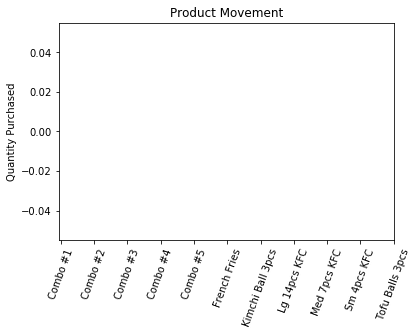

In [33]:
#bar plots want a list of integers for their x-values
x_r = range(len(x))


plt.bar(x_r,y, align='center')

#bring in the labels (names) and rotate the labels to make them easy to read
plt.xticks(x_r,x, rotation = 70)
plt.title('Product Movement')
plt.ylabel('Quantity Purchased')


plt.show()

In [34]:
print('Hot Products:\n{}\n{}\n{}' .format(x[0],x[1],x[2]))

Hot Products:
Combo #1
Combo #2
Combo #3


In [35]:
print('Slow Products:\n{}' .format(x[-3:]))

Slow Products:
8        Med 7pcs KFC
9         Sm 4pcs KFC
10    Tofu Balls 3pcs
Name: name, dtype: object


In [36]:
df['time_of_sale'] = pd.to_datetime(df['time_of_sale'])

#function to determine whether the sale was around breakfast, lunch, or dinner/evening
def t_o_d(time):
    if time.hour < 12 and time.hour >= 5:
        return 'Breakfast'
    if time.hour >= 11 and time.hour < 17:
         return 'Lunch'
    if time.hour >= 17 or time.hour < 5:
         return 'Dinner'
        
#function to determine whether the sale was on a weekend or weekday        
def week_weekend (time):
    if time.weekday() != 'saturday' and time.weekday() != 'sunday':
        return 'weekday'
    else:
        return 'weekend'

In [37]:
#if quantity is NaN then we know its a worthless entry, so we drop it
df = df.dropna(subset=['quantity'])

In [38]:
#apply our time of day function to our time of sale function
df['time_of_day'] = df.time_of_sale.apply(t_o_d)

In [39]:
#apply the weekday/weekend function
df['week_weekend'] = df.time_of_sale.apply(week_weekend)